# TS-DAR Tutorial for HP35
**Reference**: Liu, B., Boysen, J.G., Unarta, I.C. et al. Exploring transition states of protein conformational changes via out-of-distribution detection in the hyperspherical latent space. Nat Commun 16, 349 (2025). https://doi.org/10.1038/s41467-024-55228-4

---
## TS-DAR Framework: An Overview

In this notebook, we introduce **Transition State identification via Dispersion and vAriational principle Regularized neural networks (TS-DAR)**, a computational framework that utilizes out-of-distribution (OOD) detection to accurately and simultaneously identify transition states involved in specific biomolecular conformational changes. TS-DAR leverages a deep learning model to map protein conformations from molecular dynamics (MD) simulations into a hyperspherical latent space. This low-dimensional representation preserves the essential kinetic information while still capturing the protein's dynamic behavior. To distinguish metastable states from transition states, TS-DAR employs a VAMP-2 loss and dispersion loss function:

1. **VAMP-2 Loss:** Encourages the latent representation to capture the slow dynamics of the system by maximizing correlations between time-lagged data.
2. **Dispersion Loss:** Ensures that the latent space does not collapse by promoting a well-dispersed representation of the macrostates.

---

## Before starting, make sure you have done the following:

#### 1. Download and install Anaconda:
wget https://repo.anaconda.com/archive/Anaconda3-2024.06-1-Linux-x86_64.sh <br>
./Anaconda3-2024.06-1-Linux-x86_64.sh
#### 2. Create a new conda environment and install the ts-dar source code locally:
conda create -n ts-dar python=3.9 <br>
conda activate ts-dar <br>
#### 3. Install dependencies
!pip install matplotlib numpy==1.26.1 scipy==1.11.4 torch==1.13.1 tqdm==4.66.1
#### 4. Clone the repository
!git clone https://github.com/xuhuihuang/ts-dar.git
#### 5. Install the package
!python -m pip install ./ts-dar

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

from tsdart.utils import set_random_seed
from tsdart.loss import Prototypes
from tsdart.model import TSDART, TSDARTLayer, TSDARTModel, TSDARTEstimator, TSDARTModel
from tsdart.dataprocessing import Preprocessing

## Load the HP35 Data:

Please download the dataset from the link below, and place it under the base directory, unzip the file:

https://zenodo.org/records/16922765/files/HP35.zip?download=1

Change the directrory to "./HP35/".




In [ ]:
data = []
for i in range(153):
    filename = "./data/ftraj_%03d.npy" % i
    if os.path.exists(filename):  # Check if file exists
        data.append(np.load(filename))
    else:
        print(f"Warning: {filename} not found.")

## Visualize the VAMP-2 Loss:

The VAMP-2 loss is derived from the Variational Approach for Markov Processes, which aims to extract the slow collective variables from the data. Given an MD trajectory of length $T$, a batch of transition pairs $\{(x_t, x_{t+\tau})\}_{t=1}^b$ with lag time, $\tau$, is sampled. This produces two batches of data: $\mathbf{B} = [x_1, x_2, \dots, x_b]^T$ and $\mathbf{\hat{B}} = [x_{1+\tau}, x_{2+\tau}, \dots, x_{b+\tau}]^T$, which are fed into two parallel network lobes with shared parameters. Each lobe outputs SoftMax-transformed basis functions ($\chi$) applied to the input features, yielding: $\mathbf{X} = [\chi(x_1), \dots, \chi(x_b)]^T$ and $\mathbf{Y} = [\chi(x_{1+\tau}), \dots, \chi(x_{b+\tau})]^T$. The remove-mean time-instantaneous ($\bar{\mathbf{C}}_{00}$ and $\bar{\mathbf{C}}_{11}$) and time-lagged ($\bar{\mathbf{C}}_{01}$) correlation matrices can then be calculated as follows:

$$
\bar{\mathbf{C}}_{00} = \frac{1}{T - \tau} \mathbf{X}^T \mathbf{X} - \boldsymbol{\pi}_0 \boldsymbol{\pi}_0^T
$$

$$
\bar{\mathbf{C}}_{11} = \frac{1}{T - \tau} \mathbf{Y}^T \mathbf{Y} - \boldsymbol{\pi}_1 \boldsymbol{\pi}_1^T
$$

$$
\bar{\mathbf{C}}_{01} = \frac{1}{T - \tau} \mathbf{X}^T \mathbf{Y} - \boldsymbol{\pi}_0 \boldsymbol{\pi}_1^T
$$

where $\boldsymbol{\pi}_0$ and $\boldsymbol{\pi}_1$ are mean vectors of $\mathbf{X}$ and $\mathbf{Y}$, respectively, given by: $\boldsymbol{\pi}_0$ = $\frac{1}{T - \tau} \mathbf{X}^T \mathbf{1}$ and $\boldsymbol{\pi}_1$ = $\frac{1}{T - \tau} \mathbf{Y}^T \mathbf{1}$. These correlation matrices are then used to calculate the VAMP-2 loss, which is defined as:

$$
\mathcal{L}_{\text{vamp2}} = - \left\| \bar{\mathbf{C}}_{00}^{-\frac{1}{2}} \bar{\mathbf{C}}_{01} \bar{\mathbf{C}}_{11}^{-\frac{1}{2}} \right\|_{\mathcal{F}}^2 - 1
$$

Minimizing this loss drives the model to learn latent features that capture the slow dynamical modes in the molecular system.

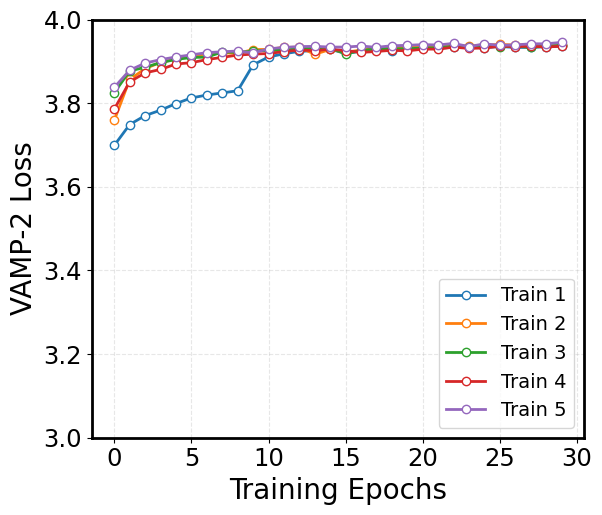

In [ ]:
val_vamp = []
for i in range(5):
    j=i+1
    file_path=rf'./4states_seed50/{j}/validation_vamp.npy'
    dip = np.load(file_path)
    val_vamp.append(dip)

# Define custom colors for the line and markers
line_color = 'royalblue'
marker_face = 'white'

plt.rcParams['font.size'] = 35

# Plot with custom colors, line width, and markers
fig = plt.figure(figsize=(8, 6))
for idx, dip in enumerate(val_vamp):
    plt.plot(dip, linewidth=2, marker='o', markersize=6, markerfacecolor=marker_face, linestyle='-', label=f'Train {idx + 1}')

# Set the axis labels
plt.xlabel('Training Epochs', fontsize=20)
plt.ylabel('VAMP-2 Loss', fontsize=20)

plt.yticks(np.arange(3, 4.1, 0.2))
plt.xticks(np.arange(0, 35, 5))

# Customize tick parameters for readability
plt.xticks(fontsize=17.5)
plt.yticks(fontsize=17.5)
plt.gca().set_box_aspect(0.85)

# Add a dashed grid to improve the readability of the plot
plt.grid(alpha=0.3, linestyle='--')
plt.legend(loc='lower right', fontsize=14, markerscale=1, ncol=1)

# Adjust the layout to ensure everything fits well
plt.tight_layout()

# Display the plot
plt.show()

## Visualize the Dispersion Loss:

While the VAMP-2 loss focuses on capturing the slow dynamics, it can sometimes result in a latent space where the features collapse to similar values. To counteract this, we incorporate a **dispersion loss** that encourages diversity in the latent space. One way to formulate the dispersion loss is by ensuring that the pairwise distances between latent representations are close to a target mean distance. The dispersion loss is defined as:

$$\mathcal{L}_{dis} = \frac{1}{C} \sum_{i=1}^{C} \log \frac{1}{C-1} \sum_{j=1}^{C} \mathbf{1}_{\{j \neq i\}} e^{\frac{\mu_i^T \mu_j}{\sigma}}$$
where:
- $C$ corresponds to the number of states.
- $\mu_i$ is a unit vector representing the mean direction of all conformations (i.e., the state center) in state $i$.
- $\sigma$ is a scaling hyperparameter, which is specifically defined as 0.1.
- $\mathbf{1}_{\{j \neq i\}}$ is an indicator function that equals 1 when $j \neq i$ (i.e., excluding self-similarity) and 0 when $j = i$.

This loss penalizes deviations from the target dispersion, ensuring that the latent features remain well-separated and informative.

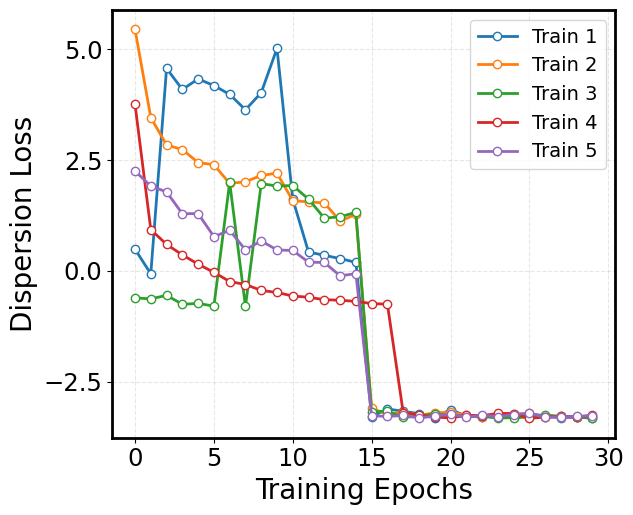

In [ ]:
# Define custom colors for the line and markers
line_color = 'royalblue'
marker_face = 'white'
#marker_edge = 'royalblue'

val_dip = []
for i in range(5):
    j=i+1
    file_path=f'./4states_seed50/{j}/validation_dis.npy'
    dip = np.load(file_path)
    val_dip.append(dip)

plt.rcParams['font.size'] = 35
plt.figure(figsize=(8, 6))
for idx, dip in enumerate(val_dip):
    plt.plot(dip, linewidth=2, marker='o', markersize=6, markerfacecolor=marker_face, linestyle='-', label=f'Train {idx + 1}')

# Set the axis labels
plt.xlabel('Training Epochs', fontsize=20)
plt.ylabel('Dispersion Loss', fontsize=20)
#plt.ylim(0, 2.25)
#plt.yticks(np.arange(0, 2.1, 0.5))
plt.xticks(np.arange(0, 35, 5))

# Customize tick parameters for readability
plt.xticks(fontsize=17.5)
plt.yticks(fontsize=17.5)
plt.gca().set_box_aspect(0.85)
plt.legend(loc='upper right', fontsize=14, markerscale=1, ncol=1)

# Add a dashed grid to improve the readability of the plot
plt.grid(alpha=0.3, linestyle='--')

# Adjust the layout to ensure everything fits well
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Initialize with specified hidden layer sizes and number of output states
lobe = TSDARTLayer([528,200,100,50,25,10,3],n_states=4)

# Load a pre-trained model - the model was trained for 30 epochs
lobe.load_state_dict(torch.load('./4states_seed50/3/model_30epochs.pytorch', map_location=torch.device('cpu')))
tsdart_model = TSDARTModel(lobe=lobe)

# Use the model to transform the input data into low-dimensional representations on the surface of a hypersphere
features = tsdart_model.transform(data,return_type='hypersphere_embs')

# Use the same model to assign each frame in the input trajectory to one of the learned states
lumped_trajs = tsdart_model.transform(data,return_type='states') # State Assignment

In [ ]:
# Initialize the TS-DAR Estimator to compute metastable state centers
tsdart_estimator = TSDARTEstimator(tsdart_model).fit(data)

# These scores indicate how far each point is from its assigned state's center, which helps detect rare conformations
ood_scores = tsdart_estimator.ood_scores

# Extract the learned centers (means) of each state in the latent hypersphere embedding space
state_centers = tsdart_estimator.state_centers

print(state_centers)

[[-0.27191687 -0.83422726 -0.47971457]
 [-0.5415171   0.7496386  -0.38052765]
 [-0.16964732 -0.0948611   0.9809287 ]
 [ 0.9731338   0.179747   -0.14388044]]


## StateAnalyzer:

The `StateAnalyzer` identifies key frames from MD data by identifying those closest to state centers and high OOD-scoring frames near state transitions in a learned embedding space.

In [ ]:
import numpy as np
import pandas as pd
import warnings

class StateAnalyzer:
    def __init__(self, state_centers, features, ood_scores):
        """
        Initialize the StateAnalyzer with state centers, features, and OOD scores.

        Parameters:
        - state_centers: List or array of state centers.
        - features: List of trajectories, where each trajectory is a list of feature vectors.
        - ood_scores: List of OOD scores corresponding to the features.
        """
        self.state_centers = state_centers
        self.features = features
        self.ood_scores = ood_scores
        self.flatten_features = np.concatenate(features)
        self.flatten_ood_scores = np.concatenate(ood_scores)
        self.indices = self._flatten_features()

    def _flatten_features(self):
        """
        Keep track of (traj_idx, frame_idx, flatten_idx).
        In case that different trajectories have different lengths, have careful record of the indices.

        Returns:
        - flatten_features: Flattened list of feature vectors.
        - indices: List of tuples containing (traj_idx, frame_idx, flatten_idx).
        """
        indices = []
        flatten_idx = 0
        for traj_idx, traj in enumerate(self.features):
            for frame_idx, f in enumerate(traj):
                indices.append((traj_idx, frame_idx, flatten_idx))
                flatten_idx += 1
        return indices

    def find_center_frames(self, center_idx=0, top_n=10):
        """
        Find the indices of the closest frames to each state center.

        Parameters:
        - num_centers: Number of state centers (default: 4).
        - top_n: Number of closest frames to return for each center (default: 10).

        Returns:
        - center_frames: DataFrame containing the closest frames for each state center.
        """
        results = []
        diff = np.linalg.norm(self.flatten_features - self.state_centers[center_idx], axis=1)

        # Find the indices of the top_n closest frames
        k = np.argsort(diff)[:top_n]

        # Extract trajectory, frame, and flattened indices
        closest_entries = [(center_idx, *self.indices[i]) for i in k]
        results.extend(closest_entries)

        # Create a DataFrame to store the results
        center_frames = pd.DataFrame(results, columns=["Center_Index", "Trajectory", "Frame", "Flatten_Index"])
        return center_frames

    def find_transition_states(self, state_idx_1, state_idx_2, threshold=0.25, top_n=10):
        """
        Find the indices of the transition states with the highest OOD scores between two states.

        Parameters:
        - state_idx_1: Index of the first state.
        - state_idx_2: Index of the second state.
        - threshold: Distance threshold for considering a feature as close to the midpoint (default: 0.25).
          Note: the threshold can't be larger than sqrt(2), not recommended to be larger than 1
        - top_n: Number of top transition states to return (default: 10).

        Returns:
        - selected_indices: Indices of the top transition states.
        - selected_ood_scores: OOD scores of the top transition states.
        """
        # Compute the midpoint between the two state centers and normalize it
        state_centers_mid = (self.state_centers[state_idx_1] + self.state_centers[state_idx_2]) / 2
        state_centers_mid /= np.linalg.norm(state_centers_mid)  # Normalize

        # Find indices where the feature is within the threshold distance from state_centers_mid
        close_indices = [i for i in range(len(self.flatten_features))
                         if np.linalg.norm(self.flatten_features[i] - state_centers_mid) < threshold]

        # Check if there are enough close frames
        if len(close_indices) < top_n:
            warnings.warn(
                f"Only {len(close_indices)} close frames found (requested {top_n}). "
                "Returning all available frames. Try increasing the threshold.",
                UserWarning,
            )
            top_n = len(close_indices)  # Adjust top_n to the number of available frames

        # Get the OOD scores corresponding to these indices
        ood_scores_filtered = self.flatten_ood_scores[close_indices]

        # Get the indices of the top N highest OOD scores from the selected frames
        top_n_indices = np.argsort(ood_scores_filtered)[-top_n:]

        # Retrieve the corresponding original indices
        selected_indices = [close_indices[i] for i in top_n_indices]

        # Get the corresponding OOD scores
        selected_ood_scores = self.flatten_ood_scores[selected_indices]

        # Create a DataFrame to store the results
        transition_data = {
            "State_1_Index": state_idx_1,
            "State_2_Index": state_idx_2,
            "OOD_Score": selected_ood_scores,
            "Flatten_Index": selected_indices,
            }

        # Add trajectory and frame indices if available
        if hasattr(self, 'indices'):
            transition_data["Trajectory"] = [self.indices[i][0] for i in selected_indices]
            transition_data["Frame"] = [self.indices[i][1] for i in selected_indices]

        transition_df = pd.DataFrame(transition_data)

        return transition_df

In [ ]:
# Initialize the StateAnalyzer
analyzer = StateAnalyzer(state_centers, features, ood_scores)

# Find the closest frames to each state center
center_idx = 2
center_frames = analyzer.find_center_frames(center_idx=center_idx)
print(f"Closest frames to state center {center_idx}:")
print(center_frames.to_string(index=False))

Closest frames to state center 2:
 Center_Index  Trajectory  Frame  Flatten_Index
            2          21   1215         211215
            2         150   2809        1502809
            2          21   2684         212684
            2         150   3540        1503540
            2         151   7972        1517972
            2          21   3911         213911
            2         128   7181        1287181
            2          45   9219         459219
            2           0   4326           4326
            2         150   9405        1509405


## Find the Transition State Conformations Between State 1 and State 2:

In [ ]:
state_idx_1 = 0
state_idx_2 = 1
transition_states = analyzer.find_transition_states(state_idx_1, state_idx_2, threshold=0.5)
print(f"Transition state between state {state_idx_1} and state {state_idx_2}:")
print(transition_states.to_string(index=False))

Transition state between state 0 and state 1:
 State_1_Index  State_2_Index  OOD_Score  Flatten_Index  Trajectory  Frame
             0              1   0.424043        1127138         112   7138
             0              1   0.424043        1127162         112   7162
             0              1   0.424273         196158          19   6158
             0              1   0.424390         455435          45   5435
             0              1   0.424422         455541          45   5541
             0              1   0.424532         196217          19   6217
             0              1   0.424601         604530          60   4530
             0              1   0.424729         195996          19   5996
             0              1   0.425174         196649          19   6649
             0              1   0.425725        1126842         112   6842


## Find the Transition State Conformations Between State 2 and State 3:

In [ ]:
state_idx_1 = 1
state_idx_2 = 2
transition_states = analyzer.find_transition_states(state_idx_1, state_idx_2)
print(f"Transition state between state {state_idx_1} and state {state_idx_2}:")
print(transition_states.to_string(index=False))

Transition state between state 1 and state 2:
 State_1_Index  State_2_Index  OOD_Score  Flatten_Index  Trajectory  Frame
             1              2   0.446738         180716          18    716
             1              2   0.446771        1501421         150   1421
             1              2   0.446950         460201          46    201
             1              2   0.447108        1123185         112   3185
             1              2   0.447181         224263          22   4263
             1              2   0.447375         224250          22   4250
             1              2   0.447526         103890          10   3890
             1              2   0.447535        1287784         128   7784
             1              2   0.448049         289471          28   9471
             1              2   0.448070         103844          10   3844


## Find the Transition State Conformations Between State 2 and State 4:

In [ ]:
state_idx_1 = 1
state_idx_2 = 3
transition_states = analyzer.find_transition_states(state_idx_1, state_idx_2, threshold=0.5)
print(f"Transition state between state {state_idx_1} and state {state_idx_2}:")
print(transition_states.to_string(index=False))

Transition state between state 1 and state 3:
 State_1_Index  State_2_Index  OOD_Score  Flatten_Index  Trajectory  Frame
             1              3   0.471023        1484781         148   4781
             1              3   0.471358        1484847         148   4847
             1              3   0.472856          41614           4   1614
             1              3   0.472881        1484808         148   4808
             1              3   0.478483          41701           4   1701
             1              3   0.479567          41628           4   1628
             1              3   0.482969          41615           4   1615
             1              3   0.483645          41700           4   1700
             1              3   0.485224          41702           4   1702
             1              3   0.489177          41626           4   1626


## Compute the Angles Between State Center Vectors:
- `angle_between_vectors` computes and prints the pairwise angles (in radians) between the state center vectors in a high dimensional embedding space to assess how uniformly dispersed the learned states are.

In [ ]:
def angle_between_vectors(v1, v2):
    """
    Calculate the angle between two vectors in radians.

    Parameters:
        v1 (array-like): First vector.
        v2 (array-like): Second vector.

    Returns:
        float: Angle in radians.
    """
    # Convert inputs to numpy arrays
    v1 = np.array(v1)
    v2 = np.array(v2)

    # Calculate dot product and magnitudes
    dot_product = np.dot(v1, v2)
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)

    # Calculate cosine of the angle
    cos_theta = dot_product / (magnitude_v1 * magnitude_v2)

    # Handle potential numerical precision issues
    cos_theta = np.clip(cos_theta, -1.0, 1.0)

    # Calculate angle in radians
    angle_radians = np.arccos(cos_theta)
    return angle_radians

# Well-dispersed data should have the angles between center vectors to be almost identical
# Useful when the dimension is larger than 3 or the number of state is larger than 4
n_states = 4
for i in range(n_states):
    for j in range(i):
        print(angle_between_vectors(state_centers[i], state_centers[j]))

1.8708554530644315
1.9233548700192482
1.9310537054099948
1.9236102600048615
1.9150272270878264
1.8999867164522164


In [ ]:
xx = [frame[0] for traj in features for frame in traj]
yy = [frame[1] for traj in features for frame in traj]
zz = [frame[2] for traj in features for frame in traj]
scores = [score for traj in ood_scores for score in traj]

print("Length of xx:", len(xx))
print("Length of yy:", len(yy))
print("Length of ood_scores:", len(scores))

Length of xx: 1526041
Length of yy: 1526041
Length of ood_scores: 1526041


## Visualize the Results in the Hyperspherical Latent Space:

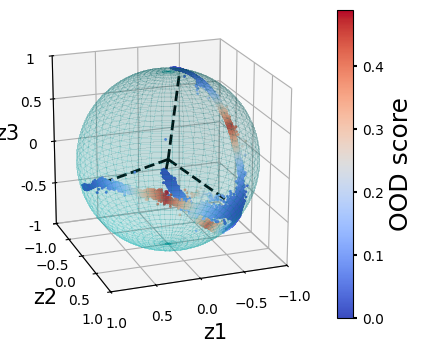

In [ ]:
r = 1
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]

x = r*sin(phi)*cos(theta)
y = r*sin(phi)*sin(theta)
z = r*cos(phi)

plt.rcParams['figure.figsize'] = (5,4)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(
   x, y, z,  rstride=2, cstride=2, color='c', alpha=0.1, linewidth=100,antialiased=False)

ax.plot([0,state_centers[0,0]],[0,state_centers[0,1]],[0,state_centers[0,2]],linewidth=2,color='black',linestyle='--')
ax.plot([0,state_centers[1,0]],[0,state_centers[1,1]],[0,state_centers[1,2]],linewidth=2,color='black',linestyle='--')
ax.plot([0,state_centers[2,0]],[0,state_centers[2,1]],[0,state_centers[2,2]],linewidth=2,color='black',linestyle='--')
ax.plot([0,state_centers[3,0]],[0,state_centers[3,1]],[0,state_centers[3,2]],linewidth=2,color='black',linestyle='--')

c = ax.scatter(xx,yy,zz,c=scores,s=1,alpha=1,cmap='coolwarm')

cb = fig.colorbar(c)
cb.ax.tick_params(labelsize=10,length=3,width=1.5)
cb.set_label('OOD score',fontsize=18)

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.set_xticks([-1,-0.5,0,0.5,1])
ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_zticks([-1,-0.5,0,0.5,1],[-1,-0.5,0,0.5,1])
ax.set_aspect("equal")
ax.tick_params(axis="both",labelsize=10,direction='out',length=7.5,width=2.5)

ax.set_xlabel('z1',fontsize=15)
ax.set_ylabel('z2',fontsize=15)
ax.set_zlabel('z3',fontsize=15)

ax.view_init(elev=20, azim=70) # Adjust these two values to have better views

In [ ]:
# This performs bootstrap resampling of transition probability matrices (TPMs) for a Markov State Model (MSM)
# using the msmbuilder package, to estimate uncertainty in the model across a range of lag times.

from msmbuilder.msm import MarkovStateModel

n_states = 4 # Number of discrete states in the MSM
num_runs = 50 # Number of bootstrap replicates
num_samples_per_run = 160 # How many trajectories to sample per bootstrap
lt = np.arange(100, 1501, 100) # Lag times to evaluate (e.g. 100, 200, ..., 1500)

# TPM generation function
def generate_TPM(trajs, lagtime, n_states=4,):
    TPM = []
    for i in range(len(lagtime)):
        msm_macro = MarkovStateModel(n_timescales=3, lag_time=lagtime[i],
                                     ergodic_cutoff='on', reversible_type='mle', verbose=False)
        msm_macro.fit(trajs)
        if len(msm_macro.transmat_) != n_states:
            return None
        TPM.append(msm_macro.transmat_)
    return np.array(TPM)

# Bootstrap loop
bootstrap_TPM = np.zeros((num_runs, len(lt), n_states, n_states))
for i in range(num_runs):
    bootstrap_indices = np.random.choice(range(len(lumped_trajs)), size=num_samples_per_run, replace=True)
    bootstrap_trajs = [lumped_trajs[i] for i in bootstrap_indices]
    temp_TPM = generate_TPM(bootstrap_trajs, lagtime=lt)
    if temp_TPM is None:
        continue
    bootstrap_TPM[i] = temp_TPM
    print('Run {} is complete'.format(i))

Run 0 is complete
Run 1 is complete
Run 2 is complete
Run 3 is complete
Run 5 is complete
Run 6 is complete
Run 8 is complete
Run 9 is complete
Run 10 is complete
Run 11 is complete
Run 12 is complete
Run 13 is complete
Run 14 is complete
Run 15 is complete
Run 16 is complete
Run 17 is complete
Run 18 is complete
Run 19 is complete
Run 20 is complete
Run 21 is complete
Run 22 is complete
Run 23 is complete
Run 24 is complete
Run 25 is complete
Run 26 is complete
Run 28 is complete
Run 29 is complete
Run 30 is complete
Run 31 is complete
Run 32 is complete
Run 33 is complete
Run 34 is complete
Run 35 is complete
Run 36 is complete
Run 37 is complete
Run 38 is complete
Run 39 is complete
Run 40 is complete
Run 41 is complete
Run 42 is complete
Run 44 is complete
Run 46 is complete
Run 47 is complete
Run 48 is complete
Run 49 is complete


## Create a Markov State Model (MSM):

- **n_timescales**: number of implied timescales to estimate
- **lag_time**: lag between transitions used to build the model
- **ergodic_cutoff**: ensures all states are connected (ergodic)
- **reversible_type**: maximum likelihood estimator for reversibility
- **verbose**: suppress output                                                 

In [ ]:
# Set the lag time for the MSM.
lagtime = 100 # In simulation steps; corresponds to 20 ns

msm = MarkovStateModel(n_timescales=6, lag_time=lagtime, ergodic_cutoff='on',
                       reversible_type='mle', verbose=False)

# Fit the MSM to the lumped trajectories (discrete state assignments per trajectory)
msm.fit(lumped_trajs)

# Extract the transition probability matrix (TPM) from the fitted MSM
transmat = msm.transmat_

# Define the number of TPM propagations to evaluate (i.e., powers of the TPM), up to 1500 simulation steps
order_parameter = np.arange(1, int(1500 / lagtime + 1))

# Convert timepoints from simulation steps to nanoseconds (0.2 ns per step)
msm_time = order_parameter * lagtime * 0.2

# Compute the TPM raised to successive powers (i.e., TPM^i), giving transition probabilities over longer times
# Each TPM^i gives the probability of transitioning from state j to k in (i × lagtime) steps
msm_TPM = []
for i in order_parameter:
    msm_TPM.append(np.linalg.matrix_power(transmat, i))

# Convert the list of TPMs into a NumPy array for further analysis or plotting
msm_TPM = np.array(msm_TPM)

## Perform a Chapman-Kolmogorov (CK) Test:
- This test is done to evaluate the markovian quality of the model by comparing the **MSM-predicted multi-step residence probabilities (from `msm_TPM`)** with the **Empirical bootstrapped MD estimates (from `bootstrap_TPM`)**



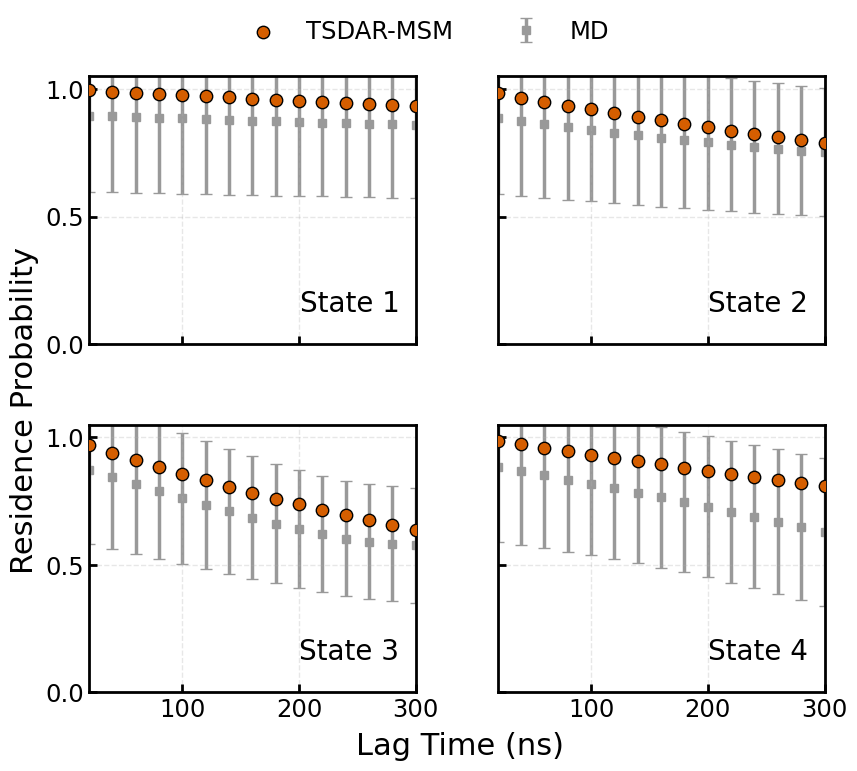

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Font and axis style
plt.rcParams['font.size'] = 17.5
plt.rcParams['axes.linewidth'] = 2

# Compute mean and std
TPM_mean = np.mean(bootstrap_TPM, axis=0)
TPM_std = np.std(bootstrap_TPM, axis=0)

color_msm = '#D55E00'
color_md = '#999999'   # gray

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(9, 7.5), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(n_states):
    ax = axes[i]

    # MD error bars
    ax.errorbar(x=lt * 0.2, y=TPM_mean[:, i, i], yerr=TPM_std[:, i, i], fmt='s', capsize=4, elinewidth=2.5, markersize=6,
                color=color_md, ecolor=color_md, zorder=1, label='MD' if i == 0 else None)

    # MSM predictions as dark blue circles
    ax.scatter(msm_time, msm_TPM[:, i, i], c=color_msm, edgecolor='k', s=80, zorder=3, label='TSDAR-MSM' if i == 0 else None)

    # State label
    ax.text(0.95, 0.10, f'State {i+1}', ha='right', va='bottom', transform=ax.transAxes, fontsize=20)

    ax.set_ylim(0, 1.05)
    ax.set_xlim(min(lt * 0.2), max(lt * 0.2))
    ax.set_xticks([100, 200, 300])
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.tick_params(axis='both', direction='in', width=2, length=6)

    # Add clean gridlines
    ax.grid(True, linestyle='--', linewidth=1, alpha=0.3)

    # Border thickness
    for spine in ax.spines.values():
        spine.set_linewidth(2)

# Axis labels
fig.text(0.54, 0.04, 'Lag Time (ns)', ha='center', fontsize=22)
fig.text(0.04, 0.5, 'Residence Probability', va='center', rotation='vertical', fontsize=22)

# Unified legend
handles, labels = [], []
for ax in axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        if l not in labels:
            handles.append(h)
            labels.append(l)

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05),
           ncol=2, fontsize=17.5, frameon=False)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.98])
plt.subplots_adjust(wspace=0.25, hspace=0.3)
plt.show()